In [10]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [17]:
# Correcting certain tickers to follow yahoo
corrections = {'ATD.B': 'ATD', 'BBD.B': 'BBD-B', 'FB': 'META', 'BT.A': 'BT-A'}

def india_num_ticker_to_yahoo_ticker(num_ticker):
    req_url = f'https://m.bseindia.com/StockReach.aspx?scripcd={num_ticker}'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36'}
    html = requests.get(req_url, headers=headers).text
    soup = BeautifulSoup(html, 'html.parser')
    return soup.find_all(lambda tag: tag.name=='tr' and "Security ID" in tag.text)[-1].text.split()[-1].strip('*') + '.BO'  # some tickers have asterisk for footnotes

def exchange_ticker_for_yahoo(row):
    if row['Exchange'] == 'Toronto Stock Exchange':
        row['Ticker'] += '.TO'
    elif row['Exchange'] == 'B3 S.A.':
        row['Ticker'] += '.SA'
    elif row['Exchange'] == 'Hong Kong Exchanges And Clearing Ltd':
        row['Ticker'] = row['Ticker'][1:] + '.HK'
    elif row['Exchange'] == 'BSE LTD':
        row['Ticker'] = india_num_ticker_to_yahoo_ticker(row['Ticker'])
    elif row['Exchange'] == 'Shenzhen Stock Exchange':
        row['Ticker'] += '.SZ'
    elif row['Exchange'] == 'Shanghai Stock Exchange':
        row['Ticker'] += '.SS'
    elif row['Exchange'] == 'BMV':
        row['Ticker'] += '.MX'
    elif row['Exchange'] == 'London Stock Exchange':
        row['Ticker'] = row['Ticker'].rstrip('.') + '.L'
    return row

def clean_industry_grp(s):
    return s.replace('&', 'and')

In [18]:
df = pd.read_excel('FINAL-22-23-Approved-Stock-List-V2_September9.xlsx')
df[['Exchange', 'GICS Sector', 'GICS Industry', 'GICS Sub-Industry', 'GICS Industry Group']] = df[['Exchange', 'GICS Sector', 'GICS Industry', 'GICS Sub-Industry', 'GICS Industry Group']].astype('category')
exchanges = df['Exchange'].unique().tolist()
exchanges

['New York Stock Exchange, Inc.',
 'Nasdaq',
 'Toronto Stock Exchange',
 'B3 S.A.',
 'Hong Kong Exchanges And Clearing Ltd',
 'BSE LTD',
 'London Stock Exchange',
 'Shenzhen Stock Exchange',
 'Shanghai Stock Exchange',
 'BMV']

In [19]:
for k, v in corrections.items():
    df.loc[df['Ticker'] == k, 'Ticker'] = v
df = df.apply(exchange_ticker_for_yahoo, axis=1)  # will take some time here as india tickers are being queried online
df['GICS Industry Group'] = df.apply(lambda row: clean_industry_grp(row['GICS Industry Group']), axis=1)

In [20]:
country = ['US', 'US', 'Canada', 'Brazil', 'HK', 'India', 'UK', 'China', 'China', 'Mexico']
country_exchange = dict(zip(exchanges, country))

In [21]:
def add_country(exchange):
    return country_exchange[exchange]

df['Country'] = df.apply(lambda row: add_country(row['Exchange']), axis=1)
df['Country'] = df['Country'].astype('category')

Country
US        319
India      59
UK         48
Brazil     40
Canada     22
China      13
HK          9
Mexico      1
dtype: int64

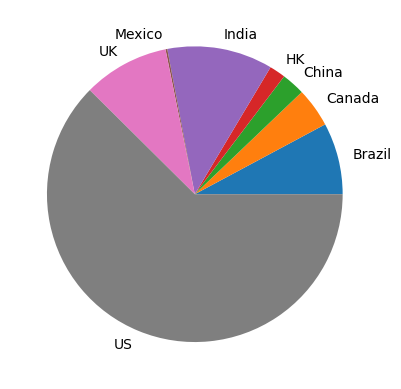

In [22]:
df.groupby('Country').size().plot.pie()
df.groupby('Country').size().sort_values(ascending=False)

GICS Sector
Consumer Discretionary    96
Financials                72
Industrials               60
Consumer Staples          49
Information Technology    48
Health Care               46
Materials                 37
Communication Services    33
Utilities                 31
Energy                    29
Real Estate               10
dtype: int64

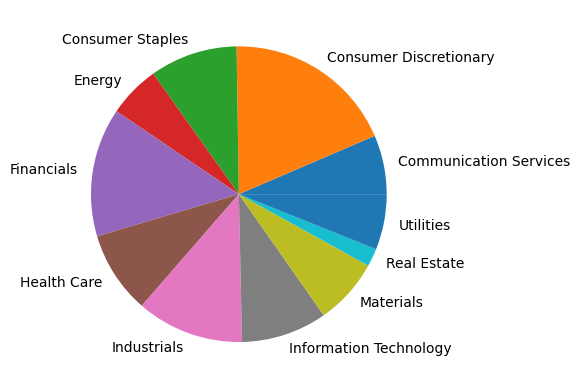

In [8]:
df.groupby('GICS Sector').size().plot.pie()
df.groupby('GICS Sector').size().sort_values(ascending=False)

In [9]:
df.groupby('GICS Industry Group').size().sort_values(ascending=False)

GICS Industry Group
Retailing                                           38
Materials                                           37
Utilities                                           31
Capital Goods                                       31
Software and Services                               31
Banks                                               31
Energy                                              29
Diversified Financials                              27
Pharmaceuticals and Biotechnology                   27
Consumer Services                                   26
Food, Beverage and Tobacco                          26
Transportation                                      23
Media and Entertainment                             22
Automobiles and Components                          16
Health Care Equipment and Services                  16
Consumer Durables and Apparel                       16
Insurance                                           14
Food and Staples Retailing                   

In [10]:
df.groupby('GICS Industry').size().sort_values(ascending=False)

GICS Industry
Banks                                         28
Oil, Gas and Consumable Fuels                 23
Specialty Retail                              22
Capital Markets                               22
Hotels, Restaurants and Leisure               21
                                              ..
Health Care Equipment & Supplies               1
Semiconductors and Semiconductor Equipment     1
Containers and Packaging                       1
Life Sciences Tools & Services                 1
Leisure Equipment & Products                   1
Length: 79, dtype: int64

In [11]:
df.groupby('GICS Sub-Industry').size().sort_values(ascending=False)

GICS Sub-Industry
Diversified Banks                       21
Pharmaceuticals                         19
Packaged Foods and Meats                13
Restaurants                             12
Application Software                    12
                                        ..
Oil & Gas Equipment & Services           1
Fertilizers & Agricultural Chemicals     1
Electronic Equipment and Instruments     1
Other Diversified Financial Services     1
Computer and Electronics Retail          1
Length: 137, dtype: int64

In [23]:
df.to_csv('yahoo_tickers.csv', index=False)